In [1]:
import numpy as np
import pandas as pd
import json, itertools, ast, folium

from ast import literal_eval
from collections import defaultdict
from geopy.geocoders import Nominatim
from folium.plugins import MarkerCluster, TagFilterButton, Search

In [2]:
######################################################################################################################
##                                     Calculations for the Map                                                     ##
######################################################################################################################


########################################
##             READ FILES             ##
########################################

def read_excel_files(file, bank = None, path = '/Users/vasou/Documents/HLA'):
    if bank:
        data = pd.read_excel(f'{path}/{bank}/{file}.xlsx')
        data = data.replace(r'\?','not found', regex = True)
        data = data.replace(np.nan,'not found')
    else:
        data = pd.read_excel(f'{path}/{file}.xlsx')
        data = data.replace(r'\?','not found', regex = True)
        data = data.replace(np.nan,'not found')
    
    return data

ibea = read_excel_files(file = 'all_ibea', bank = 'IIBEAA')
crete = read_excel_files(file = 'crete_data', bank = 'DHTOB')
database = read_excel_files(file = 'all_database')

#concatenate the two dataframes
data = pd.concat([ibea, crete], axis = 0, ignore_index=True)
data['Bank'] = ['IIBEAA']*ibea.shape[0] + ['CRETE']*crete.shape[0]


#####################################################
##             CBUs for the map                    ##
#####################################################

data_search = data

#Select omfalika
c = [string for string in list(data_search['ID'].values) if string.startswith('M0005') or string.startswith('CBBC') or string.startswith('RES')]
indexes = [data_search[data_search['ID'] == i].index[0] for i in c]

data_search = data_search.loc[indexes]

######################################################
##     drop samples without perifereiakh enothta    ##
######################################################

count_notfounds = 0
#values = [value for value in list(data_search['ΠΕΡΙΦΕΡΕΙΑΚΗ ΕΝΟΤΗΤΑ ΚΑΤΟΙΚΙΑΣ'].unique()) if 'not found' not in value]
values = []
for value in list(data_search['ΠΕΡΙΦΕΡΕΙΑΚΗ ΕΝΟΤΗΤΑ ΚΑΤΟΙΚΙΑΣ'].unique()):
    if 'not' not in value:
        values.append(value)
    else:
        count_notfounds+=1


indexes = []
for value in values:
    indexes += list(data_search[data_search['ΠΕΡΙΦΕΡΕΙΑΚΗ ΕΝΟΤΗΤΑ ΚΑΤΟΙΚΙΑΣ'] == value].index)
data_search = data_search.loc[indexes] 


#################################################
##    Choose columns for the final file        ##
#################################################

cases = ['ΠΕΡΙΦΕΡΕΙΑΚΗ ΕΝΟΤΗΤΑ ΚΑΤΟΙΚΙΑΣ', 'Bank','A_1', 'A_2', 'B_1','B_2', 'C_1', 'C_2', 'DRB1_A1', 'DRB1_A2']
      

#####################################
# 209 omfalika apo krhth kai iibeaa #
#####################################

omfalika = data_search[cases]


###############################################################
##         counting nomwn mono gia attikh kai krhth          ##
###############################################################

nomoi_lat = {}
for nomos in list(data_search['ΠΕΡΙΦΕΡΕΙΑΚΗ ΕΝΟΤΗΤΑ ΚΑΤΟΙΚΙΑΣ'].unique()):
    if nomos in list(data_search[data_search['ΠΕΡΙΦΕΡΕΙΑ ΚΑΤΟΙΚΙΑΣ'] == 'ΚΡΗΤΗΣ']['ΠΕΡΙΦΕΡΕΙΑΚΗ ΕΝΟΤΗΤΑ ΚΑΤΟΙΚΙΑΣ'].unique()):
        nomoi_lat[nomos] = data_search['ΠΕΡΙΦΕΡΕΙΑΚΗ ΕΝΟΤΗΤΑ ΚΑΤΟΙΚΙΑΣ lat/lon'][data_search[data_search['ΠΕΡΙΦΕΡΕΙΑΚΗ ΕΝΟΤΗΤΑ ΚΑΤΟΙΚΙΑΣ'] == nomos].index[0]]    
    if nomos in list(data_search[data_search['ΠΕΡΙΦΕΡΕΙΑ ΚΑΤΟΙΚΙΑΣ'] == 'ΑΤΤΙΚΗΣ']['ΠΕΡΙΦΕΡΕΙΑΚΗ ΕΝΟΤΗΤΑ ΚΑΤΟΙΚΙΑΣ'].unique()):
        nomoi_lat[nomos] = data_search['ΠΕΡΙΦΕΡΕΙΑΚΗ ΕΝΟΤΗΤΑ ΚΑΤΟΙΚΙΑΣ lat/lon'][data_search[data_search['ΠΕΡΙΦΕΡΕΙΑΚΗ ΕΝΟΤΗΤΑ ΚΑΤΟΙΚΙΑΣ'] == nomos].index[0]]    

count_nomos = {}    
for nomos in list(data_search['ΠΕΡΙΦΕΡΕΙΑΚΗ ΕΝΟΤΗΤΑ ΚΑΤΟΙΚΙΑΣ'].unique()):
    if nomos in list(data_search[data_search['ΠΕΡΙΦΕΡΕΙΑ ΚΑΤΟΙΚΙΑΣ'] == 'ΚΡΗΤΗΣ']['ΠΕΡΙΦΕΡΕΙΑΚΗ ΕΝΟΤΗΤΑ ΚΑΤΟΙΚΙΑΣ'].unique()):
        count_nomos[nomos] = len(list(data_search[data_search['ΠΕΡΙΦΕΡΕΙΑΚΗ ΕΝΟΤΗΤΑ ΚΑΤΟΙΚΙΑΣ'] == nomos].index))
    if nomos in list(data_search[data_search['ΠΕΡΙΦΕΡΕΙΑ ΚΑΤΟΙΚΙΑΣ'] == 'ΑΤΤΙΚΗΣ']['ΠΕΡΙΦΕΡΕΙΑΚΗ ΕΝΟΤΗΤΑ ΚΑΤΟΙΚΙΑΣ'].unique()):
        count_nomos[nomos] = len(list(data_search[data_search['ΠΕΡΙΦΕΡΕΙΑΚΗ ΕΝΟΤΗΤΑ ΚΑΤΟΙΚΙΑΣ'] == nomos].index))


#################################################################################################
##        Crete kai attiki de mas endiaferei h plhroforia gia perifereia, exoume nomous        ##
#################################################################################################
        

perifereies = list(data_search['ΠΕΡΙΦΕΡΕΙΑ ΚΑΤΟΙΚΙΑΣ'].unique())
perifereies = [i for i in perifereies if i != 'ΚΡΗΤΗΣ' and i != 'ΑΤΤΙΚΗΣ']
perifereies_lat = {per:data_search['ΠΕΡΙΦΕΡΕΙΑ ΚΑΤΟΙΚΙΑΣ lat/lon'][data_search[data_search['ΠΕΡΙΦΕΡΕΙΑ ΚΑΤΟΙΚΙΑΣ'] == per].index[0]] for per in perifereies}   
count_perifereies = {perifereia:len(list(data_search[data_search['ΠΕΡΙΦΕΡΕΙΑ ΚΑΤΟΙΚΙΑΣ'] == perifereia].index)) for perifereia in perifereies}   
    

##########################################
##    Just few examples for Dhmous      ##
##########################################

count_dhmoi = {'ΡΕΘΥΜΝΟΥ': 16,
               'ΦΑΙΣΤΟΥ': 5,
               'ΗΡΑΚΛΕΙΟΥ': 100,
               'ΧΑΝΙΩΝ': 48,
               'ΑΠΟΚΟΡΩΝΟΥ': 2,
               'ΑΡΧΑΝΩΝ-ΑΣΤΕΡΟΥΣΙΩΝ': 6,}

dhmoi_lat = {'ΡΕΘΥΜΝΟΥ': [35.32314, 24.50356253496733],
             'ΦΑΙΣΤΟΥ': [35.07222715, 24.83574059765102],
             'ΗΡΑΚΛΕΙΟΥ': [35.2507456, 25.0782870923221],
             'ΧΑΝΙΩΝ': [35.46586525, 24.036449472430096],
             'ΑΠΟΚΟΡΩΝΟΥ': [35.36249705, 24.159479932880544],
             'ΑΡΧΑΝΩΝ-ΑΣΤΕΡΟΥΣΙΩΝ': [35.108815, 25.139577043453734]
           }


In [3]:
#############################################################################
##                                MAPS                                     ##
#############################################################################

basemaps = {
    'Google Maps': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = True,
        control = True
    ),
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = True,
        control = True
    ),
    'Google Satellite Hybrid': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Esri Satellite': folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True
    ),
    'Thunderforest.Landscape': folium.TileLayer(
    tiles = 'https://{s}.tile.thunderforest.com/neighbourhood/{z}/{x}/{y}.png?apikey=5b930589f5a84fadae7a819b39c0b711',
    attr= '&copy; <a href="http://www.thunderforest.com/">Thunderforest</a>, &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
    apikey= '5b930589f5a84fadae7a819b39c0b711>',
    maxZoom= 22,
    overlay = True,
    control = True
    ),
    'jawg-terrain': folium.TileLayer(
    tiles = 'https://{s}.tile.jawg.io/jawg-terrain/{z}/{x}/{y}{r}.png?access-token={dPUyJgxcXDIBQF21qLcDNkKKjzAGxgsbfZvaGE6xoTtUoQbrMaJLcAZL8wenq8CD}',
    attr =  '<a href="http://jawg.io" title="Tiles Courtesy of Jawg Maps" target="_blank">&copy; <b>Jawg</b>Maps</a> &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
    accessToken = 'dPUyJgxcXDIBQF21qLcDNkKKjzAGxgsbfZvaGE6xoTtUoQbrMaJLcAZL8wenq8CD',
    overlay = True,
    control = True
    ),
    'CartoDB_Voyager': folium.TileLayer(
    tiles = 'https://{s}.basemaps.cartocdn.com/rastertiles/voyager/{z}/{x}/{y}{r}.png',
    attr =  '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
    overlay = True,
    control = True
    ),  
}



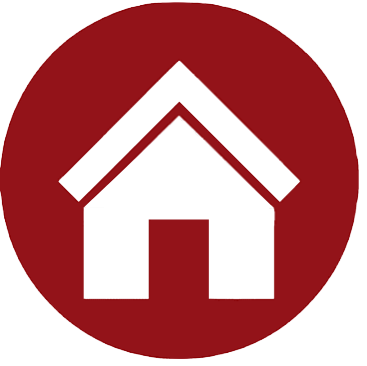
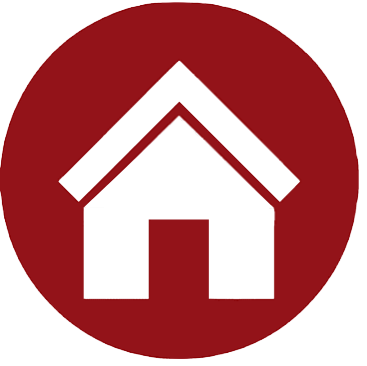
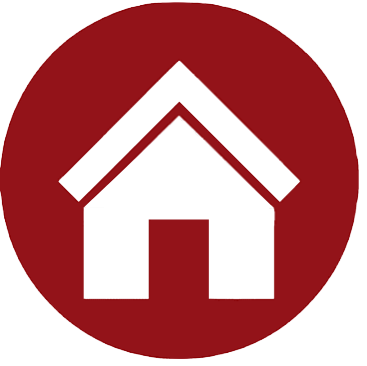
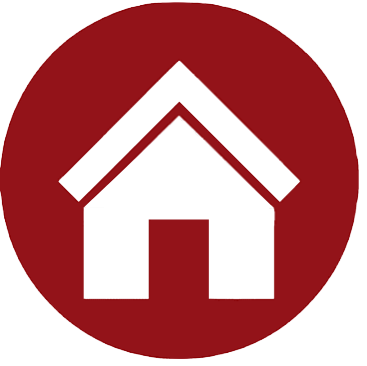
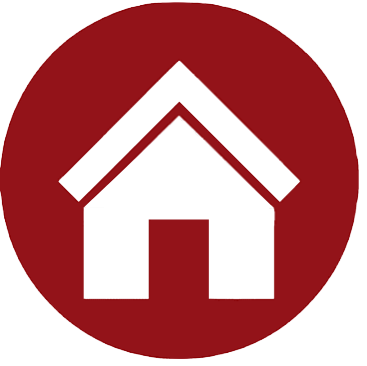
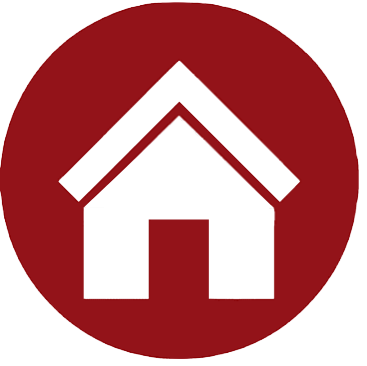

In [6]:
def map_crete(map_choice,         #Dictionary: Choose the map style.
              nomoi_lat,          #Dictionary: Nomoi with lat/lon.
              count_nomos,        #Dictionary: How many samples have each nomos.
              count_perifereies,  #Dictionary: How many samples have each perifereia.
              perifereies_lat,    #Dictionary: Perifereia with lat/lon.
              data_samples,       #DataFrame : Data for the map.
              count_dhmoi,        #Dictionary: How many samples have each Dhmos.
              dhmoi_lat           #Dictionary: Dhmos with lat/lon.
             ):
    
    
    ##############################################
    ##             Create Map                   ##
    ##############################################
    
    my_map = folium.Map(
            location=[38.9953683, 21.9877132],
            zoom_start=7,
            )
    
    ########################################################
    ##               Choose the map type                  ##
    ########################################################
    
    map_choice['Thunderforest.Landscape'].add_to(my_map)
        
    
    #######################################################
    ##             tooltip for the markers               ##
    #######################################################
    
    tooltip = "Click me!"
    
    
    #########################################################
    ##             ADD INFO FOR THE BANKS marker           ##
    #########################################################
    
    trapezes = {'IIBEAA':[37.7561803,23.66690056425356],
                'PAP'   :[40.651384050000004,23.175046284384422],
                'PATRA' :[38.2498476,21.7351217],
                'CYPRUS':[34.9823018,33.1451285],
                'EOM'   :[37.99085805,23.741474247371166],
                'CRETE' :[35.28008255, 24.638844023828177]
               }
    
    trapezes_logo = {'IIBEAA':'https://hcbb.bioacademy.gr',
                    'PAP'    :'https://aimatologiko-pap.gr',
                    'PATRA'  :'https://www.xarisezoi.gr',
                    'CYPRUS' :'https://karaiskakio.org.cy',
                    'EOM'    :'https://www.eom.gr',
                    'CRETE'  :'https://www.cordbloodbankcrete.gr'
                    }
    

    #################################################################
    ##             Create a Marker Cluster for the Banks           ##
    #################################################################
    
    marker_cluster_trapezes = MarkerCluster(name='Banks').add_to(my_map)
    
    for key in trapezes:
        html = f"""
            <a href={trapezes_logo[key]}>
            <img src="https://github.com/ioannavasilopoulou/HLA/raw/main/data/{key}_logo.png">
            </a>
            """

        custum_marker = folium.features.CustomIcon('/Users/vasou/Documents/HLA/hospital_10.png',
                                                   icon_size=(35,35)
                                                  )
        
        ##########################################
        ##     Add Bank's markers to the map    ##
        ##########################################
        
        folium.Marker(trapezes[key],
                      icon=custum_marker,
                      popup = html, 
                      name = key
                     ).add_to(marker_cluster_trapezes)
        
    
    ##################################################################
    ##             Create a Marker Cluster for the Points           ##
    ##################################################################

    marker_cluster = MarkerCluster(name='My Points').add_to(my_map)
    
    ##########################################
    ##        Add nomous in the Map         ##
    ##########################################

    for key, nomos,n in zip(nomoi_lat, list(count_nomos.keys()),count_nomos.values()):
        html=f"""
            <body style="background-color:WHITE;">
            <p style="color:black;font-family:Calibri;font-size:16px;">
            <b>ΠΕΡΙΦΕΡΕΙΑΚΗ ΕΝΟΤΗΤΑ {nomos} (n={n})
            </b></p>
            <img src="https://github.com/ioannavasilopoulou/HLA/raw/main/data/{key}.png"  style="width:400px;height:auto;">
    

            <p style="color:black;font-size:12px;"><b>HLA class I και class II loci:</b></p>
            <ul>
                <li><a href="https://ioannavasilopoulou.github.io/HLA/data/{key}_A.html">
                    <p style="font-family:Calibri;font-size: 14px;line-height:0px;">HLA-A</a></li>
                <li><a href="https://ioannavasilopoulou.github.io/HLA/data/{key}_B.html">
                    <p style="font-family:Calibri;font-size: 14px;line-height:0px;">HLA-B</a></li>
                <li><a href="https://ioannavasilopoulou.github.io/HLA/data/{key}_C.html">
                    <p style="font-family:Calibri;font-size: 14px;line-height:0px;">HLA-C</a></li>
                <li><a href="https://ioannavasilopoulou.github.io/HLA/data/{key}_DRB1.html">
                    <p style="font-family:Calibri;font-size: 14px;line-height:0px;">HLA-DRB1</a></li>
            </ul>
             """
        
        popup = folium.Popup(folium.Html(html, script=True))
        #Add markers to the map
        folium.Marker(ast.literal_eval(nomoi_lat[key]), 
                      name = nomos,
                      popup=popup,
                      icon=folium.Icon(color = 'green',icon='info-sign')).add_to(marker_cluster)
        
        
    ################################################
    ##         Add perifereies on the Map         ##
    ################################################    
        
    for key, perifereia,n in zip(perifereies_lat, list(count_perifereies.keys()),count_perifereies.values()):
        if key == 'ΔΥΤΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ':
            html=f"""
                <body style="background-color:WHITE;">
                <p style="color:black;font-family:Calibri;font-size:16px;">
                <b>ΠΕΡΙΦΕΡΕΙΑ {perifereia} (n={n})</b></p>
                 """
        else:  
            
            html=f"""
                <body style="background-color:WHITE;">
                <p style="color:black;font-family:Calibri;font-size:16px;">
                <b>ΠΕΡΙΦΕΡΕΙΑ {perifereia} (n={n})</b></p>
                <img src="https://github.com/ioannavasilopoulou/HLA/raw/main/data/{key}.png"  style="width:300px;height:auto;">
                 """
        popup = folium.Popup(folium.Html(html, script=True))
        folium.Marker(ast.literal_eval(perifereies_lat[key]), 
                      name = perifereia,
                      popup=popup,icon=folium.Icon(color = 'blue',icon='info-sign')).add_to(marker_cluster)
    
    
    ################################################
    ##          Add Dhmous on the Map             ##
    ################################################ 
    
    for key in count_dhmoi:
            
        html = f"""
            <ul>
                <li>Municipality: {key}</li>
                <li>Number of Samples: {count_dhmoi[key]}</li>
            </ul>
            """
        folium.Marker(dhmoi_lat[key], popup = html, name = key).add_to(marker_cluster)
        
        
    ##################################################
    ##         Create two groups (CBUs, BMD)        ##
    ##################################################  
        
    mc_active = folium.plugins.MarkerCluster(name='My Points',
                control=False).add_to(my_map)
    mc_unactive = folium.plugins.MarkerCluster(name='My Points',
                control=False).add_to(my_map)
    active = folium.plugins.FeatureGroupSubGroup(mc_active, "Umbilical Cord Blood")  
    unactive = folium.plugins.FeatureGroupSubGroup(mc_unactive, "Bone Marrow")
    my_map.add_child(active)
    my_map.add_child(unactive)
    my_map.add_child(mc_active)
    my_map.add_child(mc_unactive)

    ##################################################
    ##         Add search box        ##
    ##################################################

    servicesearch = Search(
                    layer = marker_cluster,
                    search_label = "name",
                    placeholder = 'Search for location',
                    collapsed = True,
                    ).add_to(my_map)
   

    folium.LayerControl().add_to(my_map)
    my_map.save("index.html")

    return my_map


map_crete(basemaps,
          nomoi_lat,
          count_nomos,
          count_perifereies,
          perifereies_lat,
          data_search,
          count_dhmoi,
          dhmoi_lat)